## Class Activation Map 실습

이번 실습에서는 ImageNet pretrained model에 대해서 class activation map을 구해봅니다 

In [1]:
## library import
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

print(tf.__version__)
print(keras.__version__)

2.0.0-beta1
2.2.4-tf


In [2]:
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input, decode_predictions

In [3]:
img_size = 224

In [4]:
## pretrained mobilenet load
mobilenet = MobileNet(weights='imagenet', include_top=True,
                     input_shape=(img_size, img_size, 3))

In [5]:
mobilenet.trainable = False
mobilenet.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [6]:
## input image를 받아서, 마지막 feature map을 출력해주는 model 생성
target_fmap = mobilenet.get_layer(name='conv_pw_13_relu').output
model = keras.models.Model(mobilenet.input, target_fmap)

In [7]:
## fully connected layer의 weight
weights = mobilenet.get_layer(name='conv_preds').get_weights()[0]
print(weights.shape)

(1, 1, 1024, 1000)


In [8]:
## weight reshape
weights = np.reshape(weights, (1024, 1000))
print(weights.shape)

(1024, 1000)


In [139]:
## test image를 읽어와서 224, 224로 resize
from PIL import Image

cur_dir = os.getcwd()
img_path = os.path.join(cur_dir, 'data', 'catdog.jpg')
currimg = Image.open(img_path)
currimg = currimg.resize((img_size, img_size))
image = np.asarray(currimg)
image = np.reshape(image, (-1, img_size, img_size, 3))
print(image.shape)

(1, 224, 224, 3)


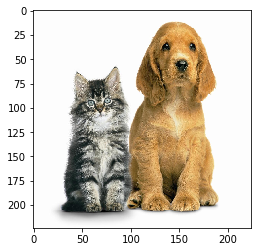

In [140]:
## 화면에 출력
plt.imshow(image[0])
plt.show()

In [141]:
## test image를 pretrained model에 넣고 feature map을 뽑음
fmap = model(preprocess_input(image))
fmap = np.reshape(np.array(fmap), (7,7,1024))
print(fmap.shape)

(7, 7, 1024)


In [142]:
## test image에 대한 top-1 class 확인
prediction = mobilenet.predict(preprocess_input(image))

pred_class = np.argmax(prediction, -1)
pred_class

array([539], dtype=int64)

In [143]:
## top-1 외에 다른 class에 대한 label에 대해서도 CAM을 수행할 수 있도록 label list 생성
label_list = np.argsort(prediction, -1)
label_list = label_list[0, ::-1]
label_list[0]

539

In [144]:
## top-5 확인
decode_predictions(prediction)

[[('n03223299', 'doormat', 0.36951762),
  ('n02100583', 'vizsla', 0.12395459),
  ('n02123045', 'tabby', 0.1105799),
  ('n04118776', 'rule', 0.027230948),
  ('n02124075', 'Egyptian_cat', 0.02276722)]]

In [110]:
## top-5 class중 원하는 class에 대한 weight 가져오기
## 예) top-1 class: label_list[0], top-2 class: label_list[1], ...
#weights_cam = weights[:, pred_class[0]]
weights_cam = weights[:, label_list[2]]

In [111]:
## CAM 만들기 (0으로 초기화한 후 weight x feature map을 누적해서 더함)
camsum = np.zeros((7,7))
for i in range(1024):
    camsum = camsum + weights_cam[i]*fmap[:,:,i]
camsum = camsum / 1024.

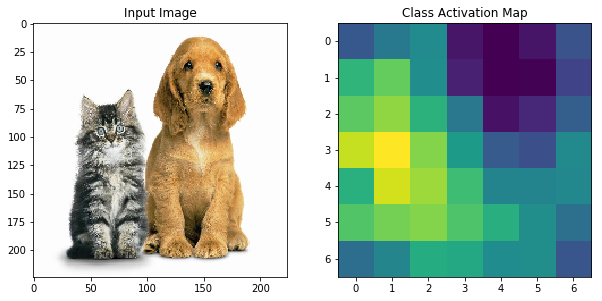

In [112]:
## 원본 image와 CAM 확인
fig1 = plt.figure(figsize=(10,6))
ax1 = fig1.add_subplot(1,2,1)
ax1.imshow(image[0])
ax1.set_title("Input Image")
ax2 = fig1.add_subplot(1,2,2)
ax2.imshow(camsum)
ax2.set_title("Class Activation Map")
plt.show()

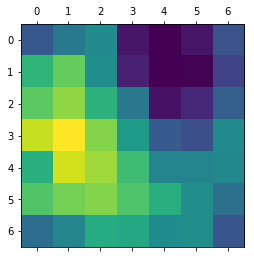

In [113]:
## CAM을 0~1사이로 scaling
camsum /= camsum.max()
plt.matshow(camsum)
plt.show()

### CAM을 image로 저장

In [114]:
import cv2

In [115]:
img = cv2.imread(img_path)
img = cv2.resize(img, (img_size, img_size))
camsum = cv2.resize(camsum, (img_size, img_size))
heatmap = np.uint8(255*camsum)

In [116]:
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

In [117]:
## 원본 image와 CAM을 어느정도 비율로 섞을지 결정
superimposed_img = heatmap * 0.4 + img * 0.7

In [118]:
## file 저장할 경로
cam_path = os.path.join(cur_dir, 'cam.jpg')

In [119]:
## file 저장
cv2.imwrite(cam_path, superimposed_img)

True

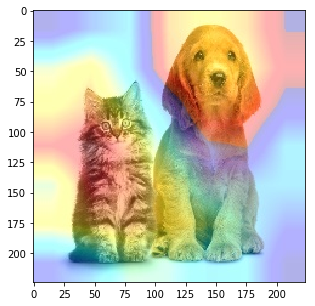

In [120]:
currimg = Image.open(cam_path)
image = np.asarray(currimg)
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.show()